In [ ]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

In [ ]:
!pip install datasets
!pip install transformers

In [ ]:
pip install --upgrade accelerate

In [ ]:
import numpy as np
from datasets import load_dataset

raw_datasets = load_dataset("imdb")


In [ ]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [ ]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:

  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:

      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]

    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


Note: The preceding code was sourced from external resource.

My implementation for DAN model is based on the article:

chrome-extension://ieepebpjnkhaiioojkepfniodjmjjihl/data/pdf.js/web/viewer.html?file=https%3A%2F%2Fpeople.cs.umass.edu%2F~miyyer%2Fpubs%2F2015_acl_dan.pdf

*This implementation uses GloVe embeddings for word representation, trained on a slightly smaller dataset compared to the original paper.

In [ ]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#The final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, dropout_rate = 0, num_hidden_layers = 0, activation_func = nn.ReLU()):

          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))

          self.dropout_rate = dropout_rate
          self.drop_out = nn.Dropout(dropout_rate)
          self.hidden_size = 256
          if num_hidden_layers == 0:
            all_layers = [nn.Linear(self.embeddings.embedding_dim, self.num_labels)]

          elif num_hidden_layers > 0:
            all_layers = [nn.Linear(self.embeddings.embedding_dim, self.hidden_size),
                          activation_func]
            for i in range(num_hidden_layers - 1):
              all_layers += [nn.Linear(self.hidden_size, self.hidden_size),
                             activation_func
                             ]
            all_layers.append(nn.Linear(self.hidden_size, self.num_labels))

          self.classifier = nn.Sequential(*all_layers)
          self.loss = nn.CrossEntropyLoss() #includes softmax inside


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      if self.training and 0 < self.dropout_rate < 1:
        attention_masks = self.drop_out(attention_masks.float()) * (1 - self.dropout_rate)
      input_embeddings =self.embeddings(input_ids)
      input_embeddings[attention_masks == 0] = 0
      avg = torch.sum(input_embeddings, dim=1)
      avg /= torch.sum(attention_masks,dim=1).unsqueeze(-1)

      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [ ]:
from transformers import Trainer
from transformers import TrainingArguments, TrainerCallback

accuracies = []
epochs = []

class AccurCallback(TrainerCallback):
    def on_init_end(self, args, state, control, **kwargs):
      accuracies = []
      epochs = []

    def on_evaluate(self, args, state, control, **kwargs):
      epochs.append(state.epoch)
      eval_acc = state.log_history[-1]["eval_accuracy"]
      accuracies.append(eval_acc)



# Accuracy of the model

In [ ]:
#i used the following Documentation https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments


co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  num_train_epochs=35,
                                  per_device_train_batch_size=64,
                                  per_device_eval_batch_size=64,
                                  learning_rate= 0.0004,
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN(0,1)


trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 AccurCallback()
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.462923,0.796240
2,0.539500,0.424336,0.808360
3,0.418200,0.414010,0.812200
4,0.396700,0.392137,0.825920
5,0.396700,0.391912,0.826000
6,0.384100,0.386056,0.829240
7,0.376700,0.381813,0.830680
8,0.379200,0.381267,0.830640
9,0.374300,0.383796,0.829240
10,0.374300,0.378073,0.832520


TrainOutput(global_step=13685, training_loss=0.3710672642655907, metrics={'train_runtime': 1035.2447, 'train_samples_per_second': 845.211, 'train_steps_per_second': 13.219, 'total_flos': 0.0, 'train_loss': 0.3710672642655907, 'epoch': 35.0})

In [ ]:
import matplotlib.pyplot as plt

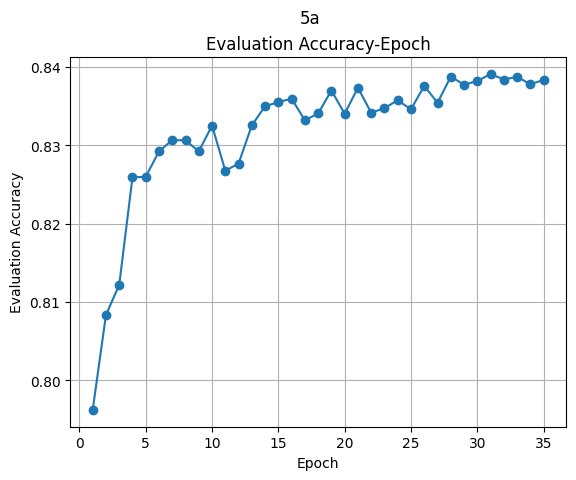

In [ ]:
plt.plot(epochs, accuracies, "-o")
plt.xlabel("Epoch")
plt.ylabel("Evaluation Accuracy")
plt.title("Evaluation Accuracy-Epoch")
plt.suptitle("5a")
plt.grid(True)
plt.show()

# *Accuracy* vs. Dropout rate

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments

def curr_model(activation_func = nn.ReLU(),dropout_rate = 0, num_hidden_layers = 1):
  co = DataCollatorWithPadding()
  training_args = TrainingArguments("DAN",
                                    num_train_epochs=35,
                                    per_device_train_batch_size=64,
                                    per_device_eval_batch_size=64,
                                    learning_rate= 0.0004,
                                    save_total_limit=2,
                                    log_level="error",
                                    evaluation_strategy="epoch")
  model = DAN(dropout_rate,num_hidden_layers,activation_func)


  trainer = Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  AccurCallback()
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  )
  trainer.train()
  return accuracies[-1]


In [ ]:
dropout_rates = [0,0.1,0.2,0.3,0.4,0.5]
drop_accuracies = [curr_model(nn.ReLU(),dropout_rate = rate,num_hidden_layers = 1) for rate in dropout_rates]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.4645523428916931, 'eval_accuracy': 0.79544, 'eval_runtime': 12.632, 'eval_samples_per_second': 1979.107, 'eval_steps_per_second': 30.953, 'epoch': 1.0}
{'loss': 0.5419, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.42449748516082764, 'eval_accuracy': 0.80832, 'eval_runtime': 12.487, 'eval_samples_per_second': 2002.089, 'eval_steps_per_second': 31.313, 'epoch': 2.0}
{'loss': 0.419, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.41502973437309265, 'eval_accuracy': 0.81132, 'eval_runtime': 12.4837, 'eval_samples_per_second': 2002.615, 'eval_steps_per_second': 31.321, 'epoch': 3.0}
{'loss': 0.3973, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.3923582434654236, 'eval_accuracy': 0.82532, 'eval_runtime': 12.481, 'eval_samples_per_second': 2003.05, 'eval_steps_per_second': 31.328, 'epoch': 4.0}
{'eval_loss': 0.3922848403453827, 'eval_accuracy': 0.8266, 'eval_runtime': 12.3073, 'eval_samples_per_second'

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.46398425102233887, 'eval_accuracy': 0.79572, 'eval_runtime': 11.8421, 'eval_samples_per_second': 2111.114, 'eval_steps_per_second': 33.018, 'epoch': 1.0}
{'loss': 0.5416, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.42289796471595764, 'eval_accuracy': 0.81052, 'eval_runtime': 12.0395, 'eval_samples_per_second': 2076.505, 'eval_steps_per_second': 32.477, 'epoch': 2.0}
{'loss': 0.4246, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.4130486249923706, 'eval_accuracy': 0.81316, 'eval_runtime': 12.3677, 'eval_samples_per_second': 2021.399, 'eval_steps_per_second': 31.615, 'epoch': 3.0}
{'loss': 0.4058, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.3930028975009918, 'eval_accuracy': 0.82604, 'eval_runtime': 12.0105, 'eval_samples_per_second': 2081.509, 'eval_steps_per_second': 32.555, 'epoch': 4.0}
{'eval_loss': 0.39175933599472046, 'eval_accuracy': 0.82644, 'eval_runtime': 11.8126, 'eval_samples_per_

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.4661979377269745, 'eval_accuracy': 0.79672, 'eval_runtime': 12.28, 'eval_samples_per_second': 2035.829, 'eval_steps_per_second': 31.84, 'epoch': 1.0}
{'loss': 0.5438, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.42864540219306946, 'eval_accuracy': 0.80616, 'eval_runtime': 12.2924, 'eval_samples_per_second': 2033.773, 'eval_steps_per_second': 31.808, 'epoch': 2.0}
{'loss': 0.4321, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.42154672741889954, 'eval_accuracy': 0.807, 'eval_runtime': 14.1522, 'eval_samples_per_second': 1766.505, 'eval_steps_per_second': 27.628, 'epoch': 3.0}
{'loss': 0.4155, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.39471063017845154, 'eval_accuracy': 0.82616, 'eval_runtime': 12.6291, 'eval_samples_per_second': 1979.55, 'eval_steps_per_second': 30.96, 'epoch': 4.0}
{'eval_loss': 0.39552417397499084, 'eval_accuracy': 0.8246, 'eval_runtime': 12.3819, 'eval_samples_per_second'

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.4666338264942169, 'eval_accuracy': 0.79732, 'eval_runtime': 11.9537, 'eval_samples_per_second': 2091.404, 'eval_steps_per_second': 32.71, 'epoch': 1.0}
{'loss': 0.5466, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.4291017949581146, 'eval_accuracy': 0.80724, 'eval_runtime': 11.5801, 'eval_samples_per_second': 2158.882, 'eval_steps_per_second': 33.765, 'epoch': 2.0}
{'loss': 0.4406, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.42451149225234985, 'eval_accuracy': 0.80468, 'eval_runtime': 12.3984, 'eval_samples_per_second': 2016.389, 'eval_steps_per_second': 31.536, 'epoch': 3.0}
{'loss': 0.4262, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.3963567912578583, 'eval_accuracy': 0.8264, 'eval_runtime': 12.4118, 'eval_samples_per_second': 2014.21, 'eval_steps_per_second': 31.502, 'epoch': 4.0}
{'eval_loss': 0.39883628487586975, 'eval_accuracy': 0.82228, 'eval_runtime': 11.8945, 'eval_samples_per_seco

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.4697227478027344, 'eval_accuracy': 0.79604, 'eval_runtime': 12.1099, 'eval_samples_per_second': 2064.419, 'eval_steps_per_second': 32.288, 'epoch': 1.0}
{'loss': 0.5519, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.43151023983955383, 'eval_accuracy': 0.80868, 'eval_runtime': 12.2931, 'eval_samples_per_second': 2033.665, 'eval_steps_per_second': 31.807, 'epoch': 2.0}
{'loss': 0.452, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.42678144574165344, 'eval_accuracy': 0.80336, 'eval_runtime': 12.3479, 'eval_samples_per_second': 2024.628, 'eval_steps_per_second': 31.665, 'epoch': 3.0}
{'loss': 0.4395, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.4002278447151184, 'eval_accuracy': 0.82568, 'eval_runtime': 12.0309, 'eval_samples_per_second': 2077.984, 'eval_steps_per_second': 32.5, 'epoch': 4.0}
{'eval_loss': 0.3990740180015564, 'eval_accuracy': 0.82356, 'eval_runtime': 11.695, 'eval_samples_per_secon

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.4746835231781006, 'eval_accuracy': 0.79588, 'eval_runtime': 12.5407, 'eval_samples_per_second': 1993.509, 'eval_steps_per_second': 31.178, 'epoch': 1.0}
{'loss': 0.5584, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.4340802729129791, 'eval_accuracy': 0.80952, 'eval_runtime': 12.516, 'eval_samples_per_second': 1997.442, 'eval_steps_per_second': 31.24, 'epoch': 2.0}
{'loss': 0.4653, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.4302401542663574, 'eval_accuracy': 0.804, 'eval_runtime': 12.3073, 'eval_samples_per_second': 2031.318, 'eval_steps_per_second': 31.77, 'epoch': 3.0}
{'loss': 0.4558, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.4063195288181305, 'eval_accuracy': 0.82356, 'eval_runtime': 12.3863, 'eval_samples_per_second': 2018.351, 'eval_steps_per_second': 31.567, 'epoch': 4.0}
{'eval_loss': 0.4055831730365753, 'eval_accuracy': 0.82132, 'eval_runtime': 12.2501, 'eval_samples_per_second':

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:3                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'plt' is not defined

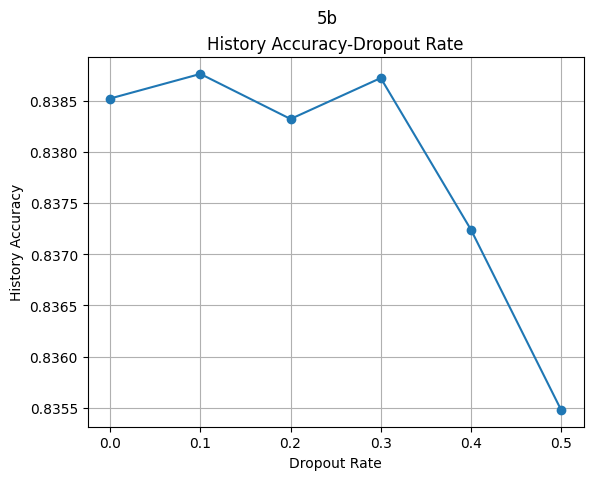

In [ ]:
plt.plot(dropout_rates, drop_accuracies, "-o")
plt.xlabel("Dropout Rate")
plt.ylabel("History Accuracy")
plt.title("History Accuracy-Dropout Rate")
plt.suptitle("5b")
plt.grid(True)
plt.show()

# *Accuracy* vs. Number of Hidden Layers

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.6473252773284912, 'eval_accuracy': 0.67936, 'eval_runtime': 12.3894, 'eval_samples_per_second': 2017.858, 'eval_steps_per_second': 31.559, 'epoch': 1.0}
{'loss': 0.6608, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.6195732355117798, 'eval_accuracy': 0.70064, 'eval_runtime': 12.4271, 'eval_samples_per_second': 2011.733, 'eval_steps_per_second': 31.464, 'epoch': 2.0}
{'loss': 0.6182, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.5987858772277832, 'eval_accuracy': 0.7178, 'eval_runtime': 12.402, 'eval_samples_per_second': 2015.811, 'eval_steps_per_second': 31.527, 'epoch': 3.0}
{'loss': 0.5929, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.5822677612304688, 'eval_accuracy': 0.72948, 'eval_runtime': 12.343, 'eval_samples_per_second': 2025.438, 'eval_steps_per_second': 31.678, 'epoch': 4.0}
{'eval_loss': 0.5682763457298279, 'eval_accuracy': 0.74084, 'eval_runtime': 12.496, 'eval_samples_per_second'

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.4614478051662445, 'eval_accuracy': 0.79668, 'eval_runtime': 11.6856, 'eval_samples_per_second': 2139.392, 'eval_steps_per_second': 33.46, 'epoch': 1.0}
{'loss': 0.5375, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.4239039719104767, 'eval_accuracy': 0.809, 'eval_runtime': 12.4929, 'eval_samples_per_second': 2001.136, 'eval_steps_per_second': 31.298, 'epoch': 2.0}
{'loss': 0.4179, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.41397401690483093, 'eval_accuracy': 0.81204, 'eval_runtime': 12.7171, 'eval_samples_per_second': 1965.864, 'eval_steps_per_second': 30.746, 'epoch': 3.0}
{'loss': 0.3966, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.3919767141342163, 'eval_accuracy': 0.82596, 'eval_runtime': 12.6566, 'eval_samples_per_second': 1975.254, 'eval_steps_per_second': 30.893, 'epoch': 4.0}
{'eval_loss': 0.3919914960861206, 'eval_accuracy': 0.82592, 'eval_runtime': 12.72, 'eval_samples_per_second'

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.4246905446052551, 'eval_accuracy': 0.80504, 'eval_runtime': 12.0084, 'eval_samples_per_second': 2081.885, 'eval_steps_per_second': 32.561, 'epoch': 1.0}
{'loss': 0.4824, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.4379710853099823, 'eval_accuracy': 0.79704, 'eval_runtime': 12.014, 'eval_samples_per_second': 2080.909, 'eval_steps_per_second': 32.545, 'epoch': 2.0}
{'loss': 0.3942, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.38390329480171204, 'eval_accuracy': 0.8306, 'eval_runtime': 12.1084, 'eval_samples_per_second': 2064.676, 'eval_steps_per_second': 32.292, 'epoch': 3.0}
{'loss': 0.3834, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.3786582946777344, 'eval_accuracy': 0.8332, 'eval_runtime': 12.1211, 'eval_samples_per_second': 2062.515, 'eval_steps_per_second': 32.258, 'epoch': 4.0}
{'eval_loss': 0.37741145491600037, 'eval_accuracy': 0.8342, 'eval_runtime': 12.4535, 'eval_samples_per_secon

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.43692561984062195, 'eval_accuracy': 0.80004, 'eval_runtime': 12.5873, 'eval_samples_per_second': 1986.131, 'eval_steps_per_second': 31.063, 'epoch': 1.0}
{'loss': 0.472, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.40841397643089294, 'eval_accuracy': 0.8126, 'eval_runtime': 12.4047, 'eval_samples_per_second': 2015.361, 'eval_steps_per_second': 31.52, 'epoch': 2.0}
{'loss': 0.398, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.390363872051239, 'eval_accuracy': 0.82512, 'eval_runtime': 12.5975, 'eval_samples_per_second': 1984.515, 'eval_steps_per_second': 31.038, 'epoch': 3.0}
{'loss': 0.3896, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.3843741714954376, 'eval_accuracy': 0.83036, 'eval_runtime': 12.529, 'eval_samples_per_second': 1995.369, 'eval_steps_per_second': 31.208, 'epoch': 4.0}
{'eval_loss': 0.37717652320861816, 'eval_accuracy': 0.83428, 'eval_runtime': 12.5185, 'eval_samples_per_second

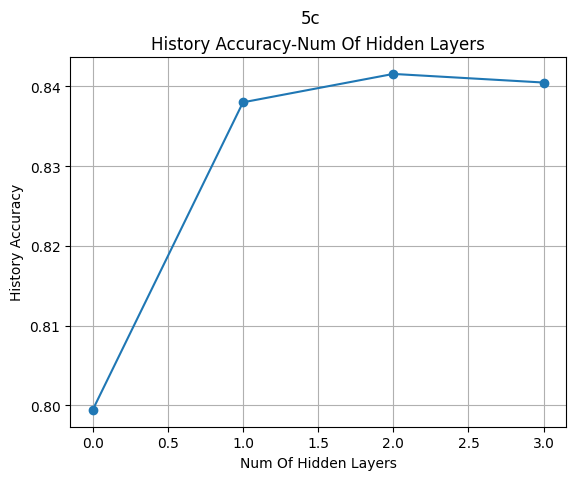

In [ ]:

num_hidden_layers_lst = [0,1,2,3]
hidden_layers_accuracies = [curr_model(nn.ReLU(),dropout_rate = 0,num_hidden_layers = num) for num in num_hidden_layers_lst]
plt.plot(num_hidden_layers_lst, hidden_layers_accuracies, "-o")
plt.xlabel("Num Of Hidden Layers")
plt.ylabel("History Accuracy")
plt.title("History Accuracy-Num Of Hidden Layers")
plt.suptitle("5c")
plt.grid(True)
plt.show()

# The accuracy across epochs for different activation functions

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.4602358937263489, 'eval_accuracy': 0.79632, 'eval_runtime': 12.0298, 'eval_samples_per_second': 2078.173, 'eval_steps_per_second': 32.503, 'epoch': 1.0}
{'loss': 0.5369, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.42428791522979736, 'eval_accuracy': 0.8082, 'eval_runtime': 12.2615, 'eval_samples_per_second': 2038.909, 'eval_steps_per_second': 31.889, 'epoch': 2.0}
{'loss': 0.4173, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.4124365746974945, 'eval_accuracy': 0.81296, 'eval_runtime': 12.3541, 'eval_samples_per_second': 2023.617, 'eval_steps_per_second': 31.649, 'epoch': 3.0}
{'loss': 0.396, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.39162203669548035, 'eval_accuracy': 0.826, 'eval_runtime': 11.9189, 'eval_samples_per_second': 2097.51, 'eval_steps_per_second': 32.805, 'epoch': 4.0}
{'eval_loss': 0.39181679487228394, 'eval_accuracy': 0.82612, 'eval_runtime': 12.0894, 'eval_samples_per_secon

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.4366057515144348, 'eval_accuracy': 0.80548, 'eval_runtime': 12.1633, 'eval_samples_per_second': 2055.369, 'eval_steps_per_second': 32.146, 'epoch': 1.0}
{'loss': 0.5144, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.4304354786872864, 'eval_accuracy': 0.80104, 'eval_runtime': 12.287, 'eval_samples_per_second': 2034.663, 'eval_steps_per_second': 31.822, 'epoch': 2.0}
{'loss': 0.407, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.39693140983581543, 'eval_accuracy': 0.82424, 'eval_runtime': 12.2047, 'eval_samples_per_second': 2048.398, 'eval_steps_per_second': 32.037, 'epoch': 3.0}
{'loss': 0.3909, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.38779351115226746, 'eval_accuracy': 0.82892, 'eval_runtime': 12.2375, 'eval_samples_per_second': 2042.9, 'eval_steps_per_second': 31.951, 'epoch': 4.0}
{'eval_loss': 0.3887239098548889, 'eval_accuracy': 0.8296, 'eval_runtime': 11.9808, 'eval_samples_per_second

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.4518892467021942, 'eval_accuracy': 0.80036, 'eval_runtime': 11.3955, 'eval_samples_per_second': 2193.855, 'eval_steps_per_second': 34.312, 'epoch': 1.0}
{'loss': 0.5284, 'learning_rate': 0.0003853854585312386, 'epoch': 1.28}
{'eval_loss': 0.4248057007789612, 'eval_accuracy': 0.80716, 'eval_runtime': 11.4897, 'eval_samples_per_second': 2175.857, 'eval_steps_per_second': 34.03, 'epoch': 2.0}
{'loss': 0.4136, 'learning_rate': 0.00037077091706247715, 'epoch': 2.56}
{'eval_loss': 0.4058059751987457, 'eval_accuracy': 0.8174, 'eval_runtime': 11.9094, 'eval_samples_per_second': 2099.181, 'eval_steps_per_second': 32.831, 'epoch': 3.0}
{'loss': 0.3936, 'learning_rate': 0.00035615637559371574, 'epoch': 3.84}
{'eval_loss': 0.389710396528244, 'eval_accuracy': 0.82704, 'eval_runtime': 11.8771, 'eval_samples_per_second': 2104.892, 'eval_steps_per_second': 32.921, 'epoch': 4.0}
{'eval_loss': 0.3894665539264679, 'eval_accuracy': 0.82748, 'eval_runtime': 12.3957, 'eval_samples_per_second

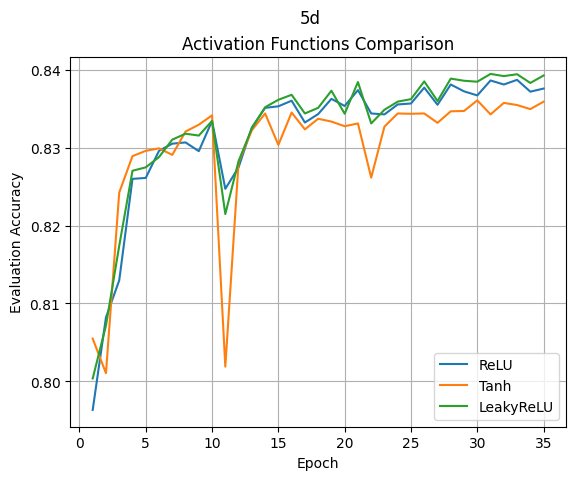

In [ ]:
activation_funcs = {'ReLU': nn.ReLU(),'Tanh': nn.Tanh(), 'LeakyReLU': nn.LeakyReLU()}

for func_name, func in activation_funcs.items():
  accuracies = []
  epochs = []
  curr_model(activation_func = func, dropout_rate = 0, num_hidden_layers = 1)
  plt.plot(epochs, accuracies, label = func_name)

plt.xlabel("Epoch")
plt.ylabel("Evaluation Accuracy")
plt.title("Activation Functions Comparison")
plt.suptitle("5d")
plt.grid(True)
plt.legend()
plt.show()